In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import urllib
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [60]:
import os

# 파일 경로 확인
image_path = '/content/drive/MyDrive/Portrit/karina.jpg'
print("파일 존재 여부:", os.path.exists(image_path))

파일 존재 여부: True


In [64]:
import torch
#model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
# 또는 아래 중 하나
#model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_mobilenet_v3_large', pretrained=True)
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride

In [65]:
# 샘플을 실행합니다. (torchvision이 필요합니다.)
from PIL import Image
from torchvision import transforms
input_image = Image.open(image_path)
input_image = input_image.convert("RGB")
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # 모델이 원하는 미니 배치를 만듭니다.

# 가능한 경우 속도를 빠르게 하기 위해 입력 및 모델을 GPU로 이동합니다.
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)

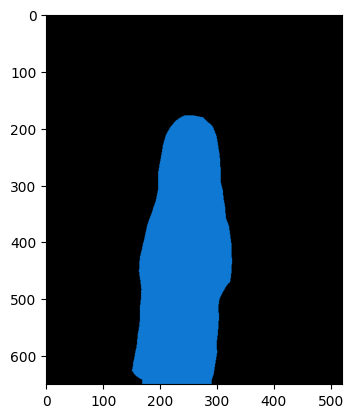

In [66]:
# 색상 팔레트를 만들고 각 클래스의 색상을 선택합니다.
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# 각 색상에서 21개 클래스의 의미론적 분할 예측을 플로팅합니다.
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)

import matplotlib.pyplot as plt
plt.imshow(r)
#plt.show()

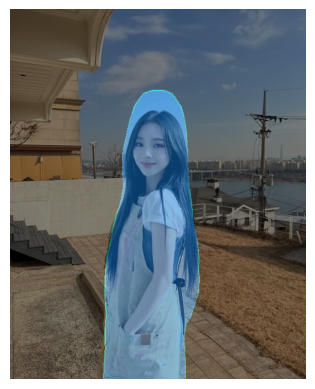

In [68]:
import torch
import torchvision.transforms as T
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# 2. 이미지 로드 및 전처리
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    preprocess = T.Compose([
        T.Resize(520),
        T.CenterCrop(512),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image_preprocessed = preprocess(image)
    image_expanded = image_preprocessed.unsqueeze(0)  # 배치 차원 추가
    return image, image_expanded

# 이미지 경로 설정
input_image, input_batch = load_and_preprocess_image(image_path)

# 가능한 경우 속도를 빠르게 하기 위해 입력 및 모델을 GPU로 이동합니다.
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

# 3. 예측 수행
with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)

# 4. 색상 팔레트 생성
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# 5. 결과 이미지 생성
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)

# 6. 원본 이미지와 결과 오버레이
r = r.convert("RGB")  # 결과 이미지를 RGB로 변환
overlay = Image.blend(input_image, r, alpha=0.5)  # 원본 이미지와 분할 결과를 혼합

# 7. 결과 저장 및 표시
#output_image_path = 'output_image_with_overlay.jpg'
#overlay.save(output_image_path)

# 결과 이미지 표시
plt.imshow(overlay)
plt.axis('off')
plt.show()